# Strain solid run through

The stages of the algorithm are as follows:

* Compute local rotation
* Compute local strain
* Compute local stress
* Compute unbalanced forces on particles
* Move the particles according to these forces

This notebook will analyse the results of each of these stages in a simple strain test case (apart from rotation and movement) by comparing them to the analytical model being approximated.

First we set up the particle system:

In [1]:
import os

os.chdir('..')

In [2]:
from scripts import sph
from scripts.sph import systems
import scripts.sph.bindings as bnd

bnd.set_log_level(2)

sph.init_opencl()

ss = systems.StrainSolid()

Then the common parameters we'll be using (making sure to collect strain, stress and force in the output):

In [3]:
import numpy as np

strain_range = np.linspace(-0.5, 0.5, num=15)
axis = 0
otheraxis1 = (axis + 1) % 3
otheraxis2 = (axis + 2) % 3

straintest_params = {
    "strain_range": strain_range,
    "axis": axis,
    "strain_rate": 0.07,
    "stabilisation_time": 10.0,
    "initial_dimensions": np.array([0.6, 0.6, 0.6]),
    "total_mass": 6.0,
    "strain_solid": ss,
    "output_fields": ["strain", "stress", "force", "cutoff_force", "density"],
    "history_particles": "all",
    "history_fields": ["position", "density", "force_elastic", "force_viscous", "strain", "stress"],
    "output_folder": "results"
}

min_edge = 4
max_edge = 9

We run some tests (this takes a while):

In [4]:
from scripts.straintest import StrainTestSymPadding

for i in range(min_edge, max_edge):
    x, y, z = np.meshgrid(np.arange(i), np.arange(i), np.arange(i), indexing='ij')
    
    all_particles = np.vstack((x.flatten(), y.flatten(), z.flatten())).T
    straintest_params['output_particles'] = all_particles
    straintest_params['particle_dimensions'] = np.array([i, i, i])
    straintest_params['output_folder'] = "results/whole_{}".format(i)
    straintest_params['smoothingradius'] = np.min(straintest_params['initial_dimensions'])/(i-1)
    
    ss.free()
    
    StrainTestSymPadding(**straintest_params).run()

Strain: 0.0
Strain: 0.0714285714285714
Strain: 0.1428571428571428
Strain: 0.2142857142857142
Strain: 0.2857142857142857
Strain: 0.3571428571428571
Something exploded or got set to nan: stopping run
The fields from the last frame are available in params['strain_solid']
Strain: 0.0
Strain: 0.0714285714285714
Strain: 0.1428571428571428
Strain: 0.2142857142857142
Strain: 0.2857142857142857
Strain: 0.3571428571428571
Strain: 0.4285714285714285
Strain: 0.5
Strain: -0.07142857142857145
Strain: -0.1428571428571429
Strain: -0.2142857142857143
Strain: -0.2857142857142857
Strain: -0.35714285714285715
Strain: -0.4285714285714286
Strain: -0.5
Strain: 0.0
Strain: 0.0714285714285714
Strain: 0.1428571428571428
Strain: 0.2142857142857142
Strain: 0.2857142857142857
Strain: 0.3571428571428571
Strain: 0.4285714285714285
Strain: 0.5
Strain: -0.07142857142857145
Strain: -0.1428571428571429
Strain: -0.2142857142857143
Strain: -0.2857142857142857
Strain: -0.35714285714285715
Strain: -0.4285714285714286
Strain

Now we can view the animated results of the tests - for example, 7x7x7:

In [5]:
from scripts.historyplayer import HistoryPlayer

h = HistoryPlayer()

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
h.play("results/whole_7")

### Results

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

Density first: average density by strain

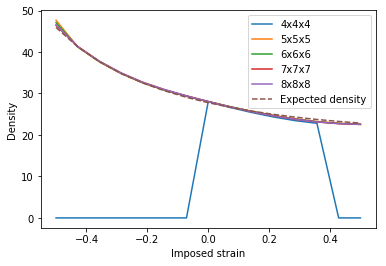

In [8]:
plt.figure(figsize=(6, 4))

for i in range(min_edge, max_edge):
    density = np.lib.format.open_memmap("results/whole_{}/density_output.npy".format(i))
    
    line, = plt.plot(strain_range, density.sum(1)/density.shape[1])
    line.set_label("{}x{}x{}".format(i, i, i))
    plt.legend()

initdims = straintest_params["initial_dimensions"]
total_mass = straintest_params["total_mass"]
poisson = ss.get_fields("poisson")[0]
line, = plt.plot(strain_range, total_mass/(1+strain_range)/(1-poisson*strain_range)**2/np.prod(initdims), '--')
line.set_label("Expected density")
plt.legend()

plt.xlabel("Imposed strain")
plt.ylabel("Density")

plt.savefig("results/density.svg")

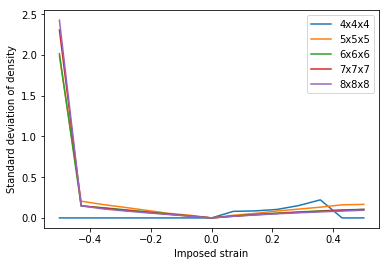

In [9]:
plt.figure(figsize=(6, 4))

for i in range(min_edge, max_edge):
    density = np.lib.format.open_memmap("results/whole_{}/density_output.npy".format(i))
    
    line, = plt.plot(strain_range, np.std(density, axis=1))
    line.set_label("{}x{}x{}".format(i, i, i))
    plt.legend()


plt.xlabel("Imposed strain")
plt.ylabel("Standard deviation of density")

plt.savefig("results/densitystd.svg")

All of these results are collected on the plane x == 0. There is at least a smoothing radius' width of padding around the sampled points shielding it from the outside.

Let's check measured strain (average) vs imposed strain first. - a few samples within the plane here instead of average?

These should be equal.

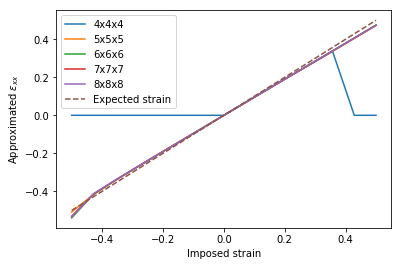

In [10]:
plt.figure(figsize=(6, 4))

for i in range(min_edge, max_edge):
    strain = np.lib.format.open_memmap("results/whole_{}/strain_output.npy".format(i))
    
    line, = plt.plot(strain_range, strain[:,:,axis].sum(1)/strain.shape[1])
    line.set_label("{}x{}x{}".format(i, i, i))
    plt.legend()

line, = plt.plot(strain_range, strain_range, '--')
line.set_label("Expected strain")
plt.legend()

plt.xlabel("Imposed strain")
plt.ylabel(r'Approximated $\varepsilon_{xx}$')
plt.savefig("results/strain.svg")

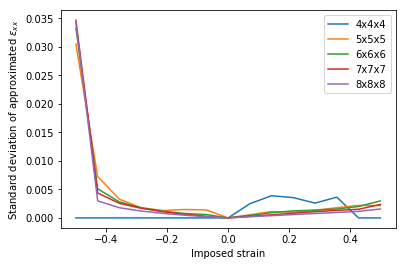

In [11]:
plt.figure(figsize=(6, 4))

for i in range(min_edge, max_edge):
    strain = np.lib.format.open_memmap("results/whole_{}/strain_output.npy".format(i))
    
    line, = plt.plot(strain_range, np.std(strain[:,:,axis], axis=1))
    line.set_label("{}x{}x{}".format(i, i, i))
    plt.legend()


plt.xlabel("Imposed strain")
plt.ylabel(r'Standard deviation of approximated $\varepsilon_{xx}$')

plt.savefig("results/strainstd.svg")

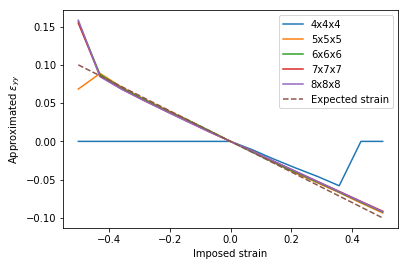

In [12]:
plt.figure(figsize=(6, 4))

for i in range(min_edge, max_edge):
    strain = np.lib.format.open_memmap("results/whole_{}/strain_output.npy".format(i))
    
    line, = plt.plot(strain_range, strain[:,:,(axis + 1) % 3].sum(1)/strain.shape[1])
    line.set_label("{}x{}x{}".format(i, i, i))
    plt.legend()

line, = plt.plot(strain_range, -poisson*strain_range, '--')
line.set_label("Expected strain")
plt.legend()

plt.xlabel("Imposed strain")
plt.ylabel(r'Approximated $\varepsilon_{yy}$')
plt.savefig("results/strainax1.svg")

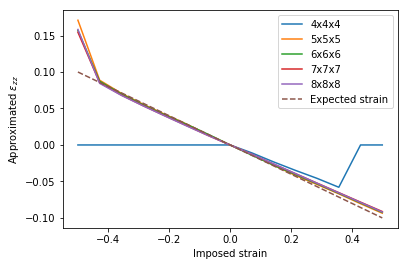

In [13]:
plt.figure(figsize=(6, 4))

for i in range(min_edge, max_edge):
    strain = np.lib.format.open_memmap("results/whole_{}/strain_output.npy".format(i))
    
    line, = plt.plot(strain_range, strain[:,:,(axis + 2) % 3].sum(1)/strain.shape[1])
    line.set_label("{}x{}x{}".format(i, i, i))
    plt.legend()

line, = plt.plot(strain_range, -poisson*strain_range, '--')
line.set_label("Expected strain")
plt.legend()

plt.xlabel("Imposed strain")
plt.ylabel(r'Approximated $\varepsilon_{zz}}$')
plt.savefig("results/strainax2.svg")

Next, stress vs measured strain. This should be a straight line, or the code is very wrong (or the particles have not yet reached equilibrium and lateral strains are contributing to the result).

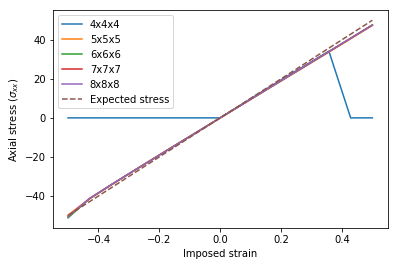

In [14]:
plt.figure(figsize=(6, 4))

for i in range(min_edge, max_edge):
    stress = np.lib.format.open_memmap("results/whole_{}/stress_output.npy".format(i))
    #strain = np.lib.format.open_memmap("results/whole_{}/strain_output.npy".format(i))
    
    #line, = plt.plot(strain[:,:,axis].sum(1)/strain.shape[1], stress[:,:,axis].sum(1)/stress.shape[1])
    line, = plt.plot(strain_range, stress[:,:,axis].sum(1)/stress.shape[1])
    line.set_label("{}x{}x{}".format(i, i, i))
    plt.legend()

stress_range = strain_range * ss.get_fields("youngs_modulus")[0]
line, = plt.plot(strain_range, stress_range, '--')
line.set_label("Expected stress")
plt.legend()

plt.xlabel("Imposed strain")
plt.ylabel(r'Axial stress ($\sigma_{xx}$)')
plt.savefig("results/stress.svg")

nan
-0.012566777513711713
-0.009890093584544957
-0.008634747598989634
-0.006147874053567648


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in float_scalars
  


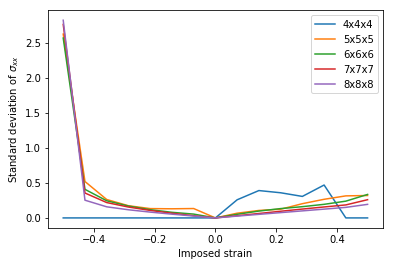

In [15]:
plt.figure(figsize=(6, 4))

for i in range(min_edge, max_edge):
    stress = np.lib.format.open_memmap("results/whole_{}/stress_output.npy".format(i))
    line, = plt.plot(strain_range, np.std(stress[:,:,axis], axis=1))
    print(np.std(stress[1,:,axis])/stress[1,:,axis].sum()*stress.shape[1])
    line.set_label("{}x{}x{}".format(i, i, i))
    plt.legend()

plt.xlabel("Imposed strain")
plt.ylabel(r'Standard deviation of $\sigma_{xx}$')
plt.savefig("results/stressstd.svg")

Finally, unbalanced forces. Assuming no shear stress components, and a uniform stress distribution, the sum of the forces over the sampling plane should be equal to the plane's area multiplied by the axial stress.

Text(0,0.5,'Planar force2.0')

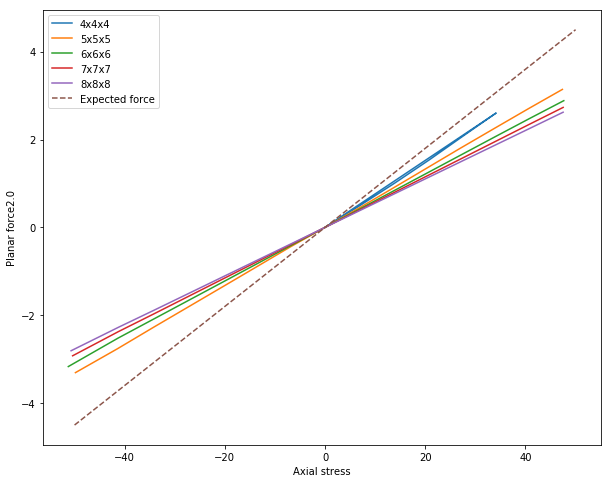

In [16]:
plt.figure(figsize=(10, 8))

for i in range(min_edge, max_edge):
    cutoff_force = np.lib.format.open_memmap("results/whole_{}/cutoff_force_output.npy".format(i))
    stress = np.lib.format.open_memmap("results/whole_{}/stress_output.npy".format(i))
    
    line, = plt.plot(stress[:,:,axis].sum(1)/stress.shape[1], cutoff_force[:,:,axis].sum(1))
    line.set_label("{}x{}x{}".format(i, i, i))
    plt.legend()

expected_force = initdims[otheraxis1] * initdims[otheraxis2] / 4 * stress_range
line, = plt.plot(stress_range, expected_force, '--')
line.set_label("Expected force")
plt.legend()

plt.xlabel("Axial stress")
plt.ylabel("Planar force2.0")